In [1]:
# Covid19 Analysis


In [2]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from datetime import datetime
from haversine import haversine, Unit
from haversine import haversine_vector

In [3]:
# reading dataset
# https://opendatasus.saude.gov.br/dataset/bd-srag-2020

df = pd.read_csv('/home/pedro/bkp/code/dataset/INFLUD-21-09-2020.csv',sep=';',encoding = "ISO-8859-1")

# Inputing constraint in the dataset 

# Positive case:

df = df[df['PCR_SARS2']==1]
print(df.shape)


# Hospitalized people:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110]
print(df.shape)

# Hospitalized people with age small than 110:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 3][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]
print(df.shape)


/home/pedro/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15,60,62,63,64,92,94,108,117,121,123) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(299142, 154)


<ipython-input-3-f1ed0beb5eec>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110]


(279982, 154)


<ipython-input-3-f1ed0beb5eec>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 3][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]


(242679, 154)


In [4]:
# Latitudes and longitudes table from municipalities

df_cod = pd.read_csv('/home/pedro/bkp/code/dataset/municipios.csv', sep=',')


In [5]:
# Removing last number from "codenumber"

df_cod['CO_MUN_RES'] = df_cod['CO_MUN_RES'].astype(str).str[:-1].astype(np.int64)
df_cod['CO_MU_INTE'] = df_cod['CO_MU_INTE'].astype(str).str[:-1].astype(np.int64)

In [6]:
# To match catalogues using muninipacity code
# latitude and longitude for pacient residence


result_01 = pd.merge(df, df_cod[['CO_MUN_RES','latitude_res','longitude_res']], on='CO_MUN_RES', how="left")
result_02 = pd.merge(df, df_cod[['CO_MU_INTE','latitude_int','longitude_int']], on='CO_MU_INTE', how="left") 

print(result_01.shape)
print(result_02.shape)

(242679, 156)
(242679, 156)


In [7]:
# To transforming in tuple

patient_mun_code  = result_01[['latitude_res','longitude_res']].to_numpy()
hospital_mun_code = result_02[['latitude_int','longitude_int']].to_numpy()


print(patient_mun_code.shape)
print(hospital_mun_code.shape)

(242679, 2)
(242679, 2)


In [8]:
# To calculate the distance from patient to hospital (difference between municipalities centers in km)

df['distance'] = haversine_vector(patient_mun_code, hospital_mun_code, Unit.KILOMETERS)

In [9]:
# To check

print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']])

        CO_MUN_RES  CO_MU_INTE     ID_MUNICIP    distance
7         351880.0    355030.0      SAO PAULO   13.951736
9         350570.0    355030.0      SAO PAULO   24.605443
10        355030.0    355030.0      SAO PAULO    0.000000
12        352670.0    352670.0           LEME    0.000000
18        355030.0    355030.0      SAO PAULO    0.000000
...            ...         ...            ...         ...
754858    330630.0    330630.0  VOLTA REDONDA    0.000000
754875    317020.0    317020.0     UBERLANDIA    0.000000
754892    291110.0    290320.0      BARREIRAS  125.383634
754896    230640.0    230440.0      FORTALEZA  118.057231
754897    330070.0    330070.0      CABO FRIO    0.000000

[242679 rows x 4 columns]


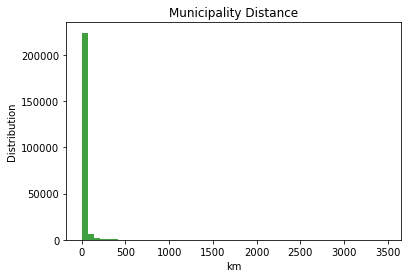

In [10]:
# Histogram for Municipality Distance

plt.hist(df['distance'], 50, density=False, facecolor='g', alpha=0.75) # .dropna(),
plt.xlabel('km')
plt.ylabel('Distribution')
plt.title('Municipality Distance')
plt.show()

In [11]:
# To check long distances

print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']][df['distance']>3000])

        CO_MUN_RES  CO_MU_INTE        ID_MUNICIP     distance
136401    431680.0    261160.0            RECIFE  3027.037343
200859    140010.0    420910.0         JOINVILLE  3479.593208
299138    421565.0    150405.0        MAE DO RIO  3019.144779
373144    110070.0    261160.0            RECIFE  3166.007414
509610    120020.0    310620.0    BELO HORIZONTE  3383.789594
573760    211120.0    430300.0  CACHOEIRA DO SUL  3195.009539
616802    260290.0    431440.0           PELOTAS  3165.723955
655586    160060.0    430910.0           GRAMADO  3261.277507
693063    431490.0    240800.0           MOSSORO  3121.907328
696975    140010.0    355030.0         SAO PAULO  3301.511571


In [12]:
print(df['distance'].max())
print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']][df['distance']>3479])                            

# Bigger distance  Boa Vista (Roraima) to Joinville (Santa Catarina)

3479.593208186318
        CO_MUN_RES  CO_MU_INTE ID_MUNICIP     distance
200859    140010.0    420910.0  JOINVILLE  3479.593208


In [13]:
# overcrowded dataset
# dataset with code from hospital (cnes) with epidemiology week and the overcrowded status of hospital.

df_cod = pd.read_csv('/home/pedro/bkp/code/dataset/hospital_overcrowded.csv', sep=',')

# CO_UNI_NOT, SEM_NOT, Overcrowded

# Overload = number of hospitalization in epidemiological week for COVID-19 / 2019 sum hospital hospitalization by SARS

In [14]:
# To check

df = pd.merge(df, df_cod, on=['CO_UNI_NOT', 'SEM_NOT'], how="left")
print(df.shape)

(242679, 156)


In [15]:
# Municipalities number inicial

# patient municipality code number
print(len(df['CO_MUN_NOT']))

# reporting health unit code number
print(len(df['CO_UNI_NOT']))


print(df['CO_MUN_NOT'].nunique())
print(df['CO_MUN_RES'].nunique())

242679
242679
1814
4401


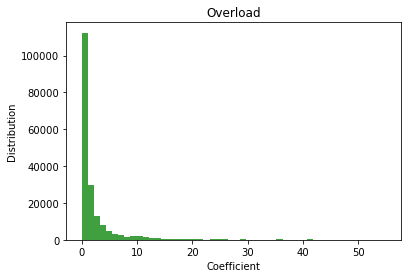

In [16]:
# Histogram for Overload

plt.hist(df['Overload'], 50, density=False, facecolor='g', alpha=0.75) # .dropna(),
plt.xlabel('Coefficient')
plt.ylabel('Distribution')
plt.title('Overload')
plt.show()

In [17]:
# IDHM

# Reading IBGE code for each municipalities and separating it for IDHM index

df_atlas = pd.read_excel (r'/home/pedro/bkp/code/dataset/AtlasBrasil_Consulta.xlsx')


# removind last interger in 'code' variable

df_atlas['code'] = df_atlas['code'].astype(str).str[:-1].astype(np.int64)


# Divinding IDHM in bins

IDHM_veryhigh  =  set(df_atlas['code'][df_atlas['IDHM2010']>=0.800])
print(len(IDHM_veryhigh))


IDHM_high  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.700)&(df_atlas['IDHM2010']<0.800))])
print(len(IDHM_high))


IDHM_medium  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.600)&(df_atlas['IDHM2010']<0.700))])
print(len(IDHM_medium))


IDHM_low  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.500)&(df_atlas['IDHM2010']<0.600))])
print(len(IDHM_low))


IDHM_verylow  =  set(df_atlas['code'][df_atlas['IDHM2010']<0.500])
print(len(IDHM_verylow))




df.loc[df['CO_MUN_NOT'].isin(IDHM_veryhigh) == True, 'IDHM'] = 5
df.loc[df['CO_MUN_NOT'].isin(IDHM_high) == True, 'IDHM'] = 4
df.loc[df['CO_MUN_NOT'].isin(IDHM_medium) == True, 'IDHM'] = 3
df.loc[df['CO_MUN_NOT'].isin(IDHM_low) == True, 'IDHM'] = 2
df.loc[df['CO_MUN_NOT'].isin(IDHM_verylow) == True, 'IDHM'] = 1



44
1890
2233
1367
32


In [18]:
# Private and public hospital separation

df_hospital = pd.read_csv('/home/pedro/bkp/code/dataset/CNES_SUS.txt', sep='\t')


public   =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='S'])
private  =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='N'])


df.loc[df['CO_UNI_NOT'].isin(public) == True, 'HEALTH_SYSTEM'] = 1
df.loc[df['CO_UNI_NOT'].isin(private) == True, 'HEALTH_SYSTEM'] = 0

# CO_UNI_NOT

In [19]:
# Constraint on dataset: We only analyze people with evolution, IDHM and Health system outcomes

df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]
print(df.shape)


<ipython-input-19-8f4afe5f8a91>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]


(231112, 158)


In [20]:
# Municipalities number

print(len(df['CO_MUN_NOT']))
print(len(df['CO_MU_INTE']))

print(df['CO_MUN_NOT'].nunique())
print(df['CO_MU_INTE'].nunique())



231112
231112
1801
1766


In [21]:
# To selecting features and target

df = df[['Overload', 'distance','NU_IDADE_N','CS_SEXO','IDHM','CS_RACA','CS_ESCOL_N','SG_UF_NOT','CS_ZONA',\
'HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP','DISPNEIA','DIARREIA',\
'SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI','DIABETES',\
'OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]


In [22]:
# adding comorbidities

df['SUM_COMORBIDITIES'] = df.iloc[:,19:-1].replace([9,2], 0).fillna(0).sum(axis=1)

In [23]:
# Ordering features

df = df[['Overload','distance','NU_IDADE_N','CS_SEXO','CS_RACA','IDHM','CS_ESCOL_N','SG_UF_NOT','SUM_COMORBIDITIES',\
'HEALTH_SYSTEM','CS_ZONA','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI',\
'DIABETES','OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]

In [24]:
# Pre-Processing

df = df[df['EVOLUCAO'].notnull()][df['EVOLUCAO']!=9][df['EVOLUCAO']!=3]#[df_BR['NU_IDADE_N'].notnull()]
df['CS_SEXO']=df['CS_SEXO'].replace({'M': 1, 'F':0, 'I':9, 'NaN':np.nan})


# replacing 2 by 0 (Death patients)
df.iloc[:,11:] = df.iloc[:,11:].replace(to_replace = 2.0, value =0) 


df['SG_UF_NOT'] = df['SG_UF_NOT'].map({'SP': 0, 'RJ':1, 'MG': 2 , 'ES':3, \
'RS':4, 'SC': 5, 'PR': 6, 'MT': 7, 'MS': 8, 'GO':9, 'DF':10, 'RO':11,'AC':12,'AM':13,\
'RR':14,'PA':15,'AP':16,'TO':17,'MA':18,'PI':19,'BA':20,'CE':21,'RN':22,'PB':23,'PE':24,'AL':25,'SE':26})

# For missing values in comorbidities and symptoms we filled by 0.
df.iloc[:,11:-1] = df.iloc[:,11:-1].fillna(0)



In [25]:
# Ordering features

df = df[['Overload','distance','NU_IDADE_N','CS_SEXO','CS_RACA','IDHM','CS_ESCOL_N','SG_UF_NOT','SUM_COMORBIDITIES',\
'HEALTH_SYSTEM','CS_ZONA','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI',\
'DIABETES','OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]


df = df.rename(columns={'Overload':'Hospital strain','distance':'Distance to hospital','NU_IDADE_N':'Age','CS_SEXO':'Sex','CS_RACA':'Ethnicity','IDHM':'MHDI',\
'CS_ESCOL_N':'Education','SG_UF_NOT':'State','SUM_COMORBIDITIES':'Num Comorbidities',\
'HEALTH_SYSTEM':'Hospital funding','CS_ZONA':'City type','CARDIOPATI':'Cardiovascular disease','HEPATICA':'Liver disease',\
'ASMA':'Asthma','PNEUMOPATI':'Pulmonary disease','RENAL':'Renal disease','HEMATOLOGI':'Hematologic disease',\
'DIABETES':'Diabetes','OBESIDADE':'Obesity','NEUROLOGIC':'Neurological disease',\
'IMUNODEPRE':'Immunosuppression','EVOLUCAO':'EVOLUCAO'})

In [26]:
# To analyse the Nan of Distance and Overload features
print(df.shape)
print(df['Hospital strain'].isna().sum())
print(df['Distance to hospital'].isna().sum())

(231112, 22)
49983
7334


In [27]:
# feature
x = df.iloc[:,:-1]

# labels
y = df['EVOLUCAO']

In [28]:
# data separation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=5)

In [29]:
print(y_train.shape)
print(y_test.shape)

(184889,)
(46223,)


In [30]:

params = params = { 'booster ':['gbtree'],
        'n_estimators': [200],          
        'eta':[0.2],    
        'max_depth':[4],
        'gamma': [1],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
            }


#{'booster ': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.2, 'gamma': 1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
                            
                            
xgb = XGBClassifier()
gs = GridSearchCV(estimator=xgb, param_grid=params, return_train_score=True, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train, y_train)


print(gs.best_score_)
print(gs.best_params_)


print(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['std_test_score'])

print(gs.cv_results_['mean_train_score'])   
print(gs.cv_results_['std_train_score'])   


clf = gs.best_estimator_
clf.fit(x_train, y_train)


# save the model to disk
filename_nn = 'xgb_without_symptoms.sav'
pickle.dump(clf, open(filename_nn, 'wb')) 


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:44:53] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:05] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:16] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:27] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:38] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:49] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:00] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:46:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:11] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:46:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:22] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:46:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:34] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:46:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:45] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:46:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7938745277044718
{'booster ': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.2, 'gamma': 1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
[0.79387453]
[0.00330046]
[0.80473977]
[0.00059207]
[21:46:57] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some para

In [30]:
# load the model from disk
loaded_model_xgb = pickle.load(open('xgb_without_symptoms.sav', 'rb'))

In [31]:
# To predicting 
xgb_pred = loaded_model_xgb.predict_proba(x_test)

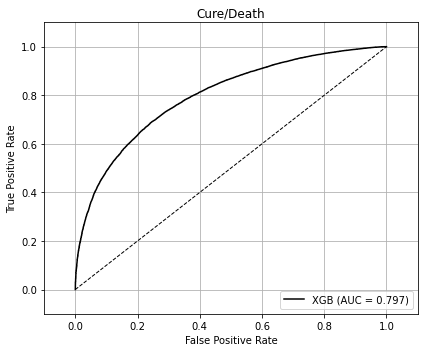

In [32]:
# Plot Roc Curve

colors = ['blue']
linestyles = ['--']
plt.figure(figsize=(6,5))
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred[:,1],pos_label=1)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr,
             color='k',
             linestyle='-',
             label='%s (AUC = %0.3f)' % ('XGB', roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='black',
         linewidth=1)

plt.title('')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.title('Cure/Death')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.savefig('roc_xgb_without_symptoms.pdf')
plt.show()  

In [33]:
# Normalization

print(len(xgb_pred[:,0][y_test == 0]))

17357


In [34]:
# Probability for dead people in bins

death_prob = xgb_pred[:,0][y_test == 0]

In [35]:
# Mean Probability for dead people in differents bins

a1 = np.average(death_prob[(death_prob>=0.8) & (death_prob<=1.0)])
b1 = np.average(death_prob[(death_prob>=0.6) & (death_prob<0.8)])
c1 = np.average(death_prob[(death_prob>=0.4) & (death_prob<0.6)])
d1 = np.average(death_prob[(death_prob>=0.2) & (death_prob<0.4)])
e1 = np.average(death_prob[(death_prob>=0.0) & (death_prob<0.2)])


print(e1)
print(np.average(death_prob[(death_prob>=0.0) & (death_prob<0.2)]))


print(c1)
print(np.average(death_prob[(death_prob>=0.4) & (death_prob<0.6)]))

# All right

0.13245292
0.13245292
0.506885
0.506885


In [36]:
# Dead people between bins (Normalization)

a2 = len(death_prob[(death_prob>=0.8) & (death_prob<=1.0)])
b2 = len(death_prob[(death_prob>=0.6) & (death_prob<0.8)])
c2 = len(death_prob[(death_prob>=0.4) & (death_prob<0.6)])
d2 = len(death_prob[(death_prob>=0.2) & (death_prob<0.4)])
e2 = len(death_prob[(death_prob>=0.0) & (death_prob<0.2)])


print(a2)
print(b2)
print(c2)
print(d2)
print(e2)


# All right

1456
5770
5336
3494
1301


In [37]:
# General number of people in bins

gen_prob = xgb_pred[:,0]


a3 = len(gen_prob[(gen_prob>=0.8) & (gen_prob<=1.0)])
b3 = len(gen_prob[(gen_prob>=0.6) & (gen_prob<0.8)])
c3 = len(gen_prob[(gen_prob>=0.4) & (gen_prob<0.6)])
d3 = len(gen_prob[(gen_prob>=0.2) & (gen_prob<0.4)])
e3 = len(gen_prob[(gen_prob>=0.0) & (gen_prob<0.2)])


print(len(gen_prob))
print(a3)
print(b3)
print(c3)
print(d3)
print(e3)


# All right

46223
1702
8277
10707
11759
13778


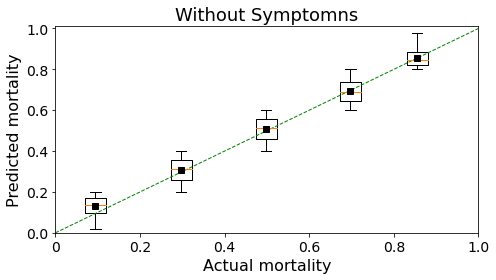

In [42]:

#  y= boxplot probability (IC)    [ death_prob[(death_prob>=0.8) & (death_prob<=1.0) , ...]
#  x= real value                  [ a2/a3 , b2/b3, c2/c3, d2/d3, e2/e3]

import matplotlib.ticker as ticker


pos = [round(e2/e3,3), round(d2/d3,3), round(c2/c3,3), round(b2/b3,3), round(a2/a3,3)]


fig = plt.figure(1, figsize=(7, 4))

ax = fig.add_subplot(111)


all_data = [death_prob[(death_prob>=0.0) & (death_prob<0.2)],
            death_prob[(death_prob>=0.2) & (death_prob<0.4)],
            death_prob[(death_prob>=0.4) & (death_prob<0.6)],
            death_prob[(death_prob>=0.6) & (death_prob<0.8)],
            death_prob[(death_prob>=0.8) & (death_prob<=1.0)]]
            
            
            

# Create the boxplot
bp = ax.boxplot(all_data, widths = 0.05, positions=pos, showfliers=False, sym='k+', showmeans=True, \
meanprops={"marker":"s","markerfacecolor":"black","markeredgecolor":"black"}, bootstrap=12000)


#ax.set_xticklabels(labels=labels,fontsize=19)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Predicted mortality',fontsize=16)
plt.xlabel('Actual mortality',fontsize=16)
#plt.scatter(y, x)
plt.setp(bp['fliers'], markersize=3.0)
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.title('Without Symptomns',size=18)
plt.plot([0, 1], [0, 1], 'g--',linewidth=1)
plt.xticks([0,0.2,0.4,0.6,0.8,1], [0,0.2,0.4,0.6,0.8,1.0])
plt.tight_layout()
plt.savefig('calibration_without_symptoms.pdf')
plt.show()
plt.close()

In [43]:
print(pos)

[0.094, 0.297, 0.498, 0.697, 0.855]


In [44]:
print(round(e2/e3,3))

0.094
